/tmp/ipython-input-2548748075.py:26: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


100%|██████████| 400k/400k [00:00<00:00, 1.04MB/s]

Extracting zip of housing.csv...
Dataset Shape: (20640, 10)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY



Multiple Linear Regression
----------------------------------------
MAE : 51810.48362804262
RMSE: 71133.17349286025
R²  : 0.6138664756435176

Best Ridge Alpha: {'alpha': 10}

Ridge Regression
----------------------------------------
MAE : 51791.94965691574
RMSE: 71099.64495383979
R²  : 0.6142303970361871

Best Lasso Alpha: {'alpha': 10}

Lasso Regression
----------------------------------------
MAE : 51808.37913077907
RMSE: 71127.20850637883
R²  : 0.6139312326216487


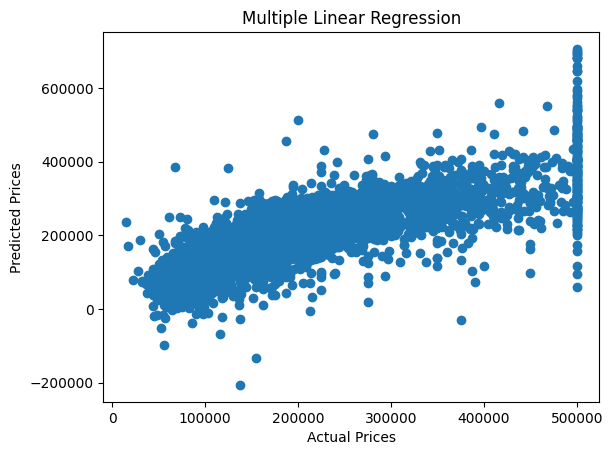

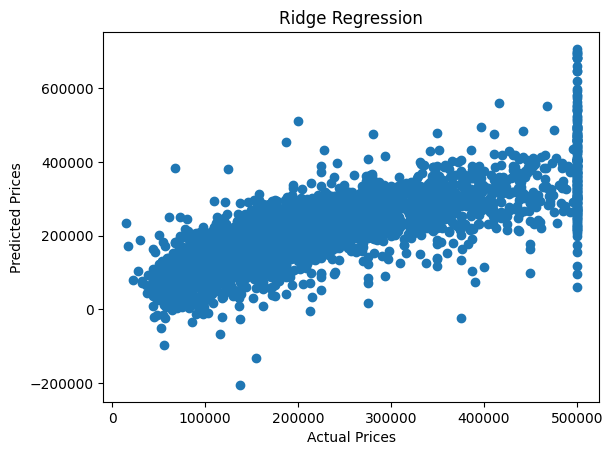

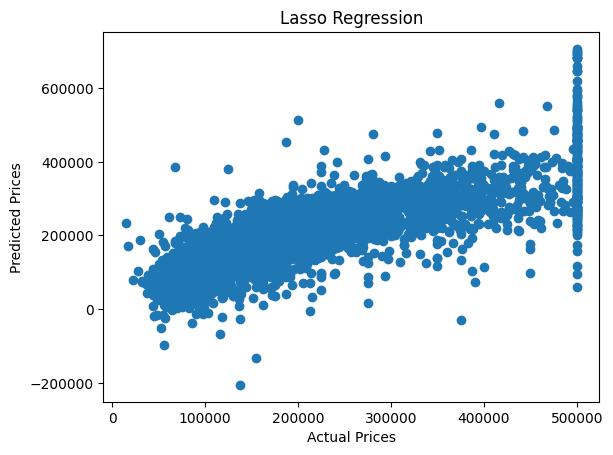

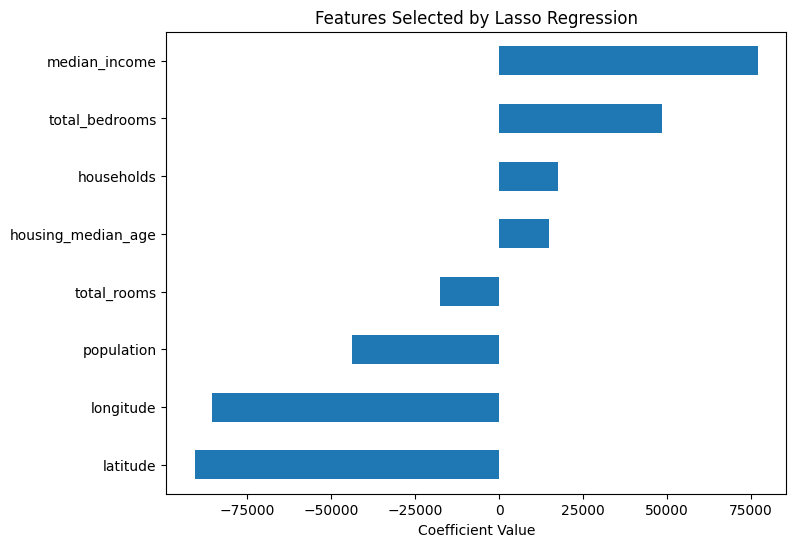

In [2]:
# ==========================================================
# Multiple Linear, Ridge & Lasso Regression (KaggleHub Ready)
# ==========================================================

# Install kagglehub
!pip install kagglehub[pandas-datasets]

# Imports
import kagglehub
from kagglehub import KaggleDatasetAdapter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# -------------------------
# Load Dataset from Kaggle
# -------------------------
file_path = "housing.csv"

df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "camnugent/california-housing-prices",
    file_path
)

print("Dataset Shape:", df.shape)
display(df.head())

# -------------------------
# Data Preprocessing
# -------------------------
# Drop categorical column for simplicity
df = df.drop(columns=["ocean_proximity"])

# Handle missing values
df = df.fillna(df.median())

X = df.drop("median_house_value", axis=1)
y = df["median_house_value"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -------------------------
# Evaluation Function
# -------------------------
def evaluate(name, y_true, y_pred):
    print(f"\n{name}")
    print("-" * 40)
    print("MAE :", mean_absolute_error(y_true, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("R²  :", r2_score(y_true, y_pred))

# -------------------------
# 1. Multiple Linear Regression
# -------------------------
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

evaluate("Multiple Linear Regression", y_test, y_pred_lr)

# -------------------------
# 2. Ridge Regression (Tuned)
# -------------------------
ridge_params = {"alpha": [0.01, 0.1, 1, 10, 100]}

ridge_grid = GridSearchCV(
    Ridge(),
    ridge_params,
    cv=5,
    scoring="neg_mean_squared_error"
)

ridge_grid.fit(X_train_scaled, y_train)
ridge_best = ridge_grid.best_estimator_

y_pred_ridge = ridge_best.predict(X_test_scaled)

print("\nBest Ridge Alpha:", ridge_grid.best_params_)
evaluate("Ridge Regression", y_test, y_pred_ridge)

# -------------------------
# 3. Lasso Regression (Tuned)
# -------------------------
lasso_params = {"alpha": [0.001, 0.01, 0.1, 1, 10]}

lasso_grid = GridSearchCV(
    Lasso(max_iter=5000),
    lasso_params,
    cv=5,
    scoring="neg_mean_squared_error"
)

lasso_grid.fit(X_train_scaled, y_train)
lasso_best = lasso_grid.best_estimator_

y_pred_lasso = lasso_best.predict(X_test_scaled)

print("\nBest Lasso Alpha:", lasso_grid.best_params_)
evaluate("Lasso Regression", y_test, y_pred_lasso)

# -------------------------
# Visualization: Actual vs Predicted
# -------------------------
plt.figure()
plt.scatter(y_test, y_pred_lr)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Multiple Linear Regression")
plt.show()

plt.figure()
plt.scatter(y_test, y_pred_ridge)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Ridge Regression")
plt.show()

plt.figure()
plt.scatter(y_test, y_pred_lasso)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Lasso Regression")
plt.show()

# -------------------------
# Lasso Feature Selection
# -------------------------
lasso_coeffs = pd.Series(
    lasso_best.coef_,
    index=X.columns
)

selected = lasso_coeffs[lasso_coeffs != 0].sort_values()

plt.figure(figsize=(8, 6))
selected.plot(kind="barh")
plt.title("Features Selected by Lasso Regression")
plt.xlabel("Coefficient Value")
plt.show()
